In [116]:
import tstrippy
import astropy.units as u
import astropy.constants as const
import astropy.coordinates as coord
import numpy as np
import matplotlib.pyplot as plt
import datetime

## How to test the bar? 

## Load the units

In [117]:
unitbasis = tstrippy.Parsers.potential_parameters.unitbasis
unitT=u.Unit(unitbasis['time'])
unitV=u.Unit(unitbasis['velocity'])
unitD=u.Unit(unitbasis['distance'])
unitM=u.Unit(unitbasis['mass'])
unitG=u.Unit(unitbasis['G'])
G = const.G.to(unitG).value

## Load Galactic Parameters

In [118]:
MWparams = tstrippy.Parsers.potential_parameters.pouliasis2017pii()
MWrefframe= tstrippy.Parsers.potential_parameters.MWreferenceframe()

## Add the bar parameters

In [119]:
Mbar = 990.0*2.32*1e7 * unitM

In [120]:
# mass and size
abar = 4 * unitD
bbar = 1 * unitD
cbar = 0.5 * unitD
Mbar = 990.0*2.32*1e7 * unitM
barparams = [MWparams[0],Mbar.value,abar.value,bbar.value,cbar.value]
# oreitnation and bar pattern speed
theta0= 25 * (np.pi/180) 
omega =  28  * 2*np.pi * unitV / unitD
omega = -omega.value
barpolycoeff=[theta0,omega]

## Reduce the mass of the disks
we are allocating it to the bar

In [121]:
MWparams[5] = 1120.0 * 2.32*10**7 
MWparams[8] = 1190.0 * 2.32*10**7 

## Set integration time

Do this in years so that you can assure the number of timesteps is an integer, and then convert the total time *T* and the timestep *dt* into integration units.

In [138]:
# make the timesteps go backward!
integrationTime = 5e9
timestep = 1e5
# change the sign because we are going backward in time 
T,dt = integrationTime, timestep
Ntimestep=int(T/dt)
T,dt=T*u.yr,dt*u.yr
T,dt=T.to(unitT),dt.to(unitT)
# we start at today
currenttime = 0.0 * unitT

## Load the Globular Clusters
Store them in an astropy object to store them to galactocentric coordinates

In [139]:
GCdata  =   tstrippy.Parsers.baumgardtMWGCs().data
skycoordinates=coord.SkyCoord(
    ra=GCdata['RA'],
    dec=GCdata['DEC'],
    distance=GCdata['Rsun'],
    pm_ra_cosdec=GCdata['mualpha'],
    pm_dec=GCdata['mu_delta'],
    radial_velocity=GCdata['RV'],)
galacticcoordinates = skycoordinates.transform_to(MWrefframe)
x,y,z=galacticcoordinates.cartesian.xyz.to(unitD).value
vx,vy,vz=galacticcoordinates.velocity.d_xyz.to(unitV).value
# SEND THEM BACKWARD 
# vx,vy,vz=-vx,-vy,-vz
# grab the number of objects
Nobj=len(x)

## Initialize the integrator

In [140]:
tstrippy.integrator.setstaticgalaxy("pouliasis2017pii",MWparams)
tstrippy.integrator.setbackwardorbit()
tstrippy.integrator.setinitialkinematics(x,y,z,vx,vy,vz)
tstrippy.integrator.setintegrationparameters(currenttime.value,dt.value,Ntimestep)
tstrippy.integrator.initgalacticbar("longmuralibar",barparams,barpolycoeff)
starttime=datetime.datetime.now()
xt,yt,zt,vxt,vyt,vzt=tstrippy.integrator.leapfrogintime(Ntimestep,Nobj)
endtime=datetime.datetime.now()
print(tstrippy.integrator.currenttime)
tstrippy.integrator.deallocate()

-5.113560825224146


## Analyize the change in energy

In [141]:
E0 = np.zeros(Nobj)
_,_,_,phi0=tstrippy.potentials.pouliasis2017pii(MWparams,xt[:,0],yt[:,0],zt[:,0])
_,_,_,phiF=tstrippy.potentials.pouliasis2017pii(MWparams,xt[:,-1],yt[:,-1],zt[:,-1])
T0 = 0.5*(vxt[:,0]**2+vyt[:,0]**2+vzt[:,0]**2)
TF = 0.5*(vxt[:,-1]**2+vyt[:,-1]**2+vzt[:,-1]**2)

E0 = T0 + phi0
EF = TF + phiF
Lz0 = xt[:,0]*vyt[:,0]-yt[:,0]*vxt[:,0]
LzF = xt[:,-1]*vyt[:,-1]-yt[:,-1]*vxt[:,-1]

In [142]:
import matplotlib
colors = matplotlib.cm.rainbow(np.linspace(0,1,Nobj))

# make the font size bigger and also us Latex font
plt.rc('text', usetex=True)
plt.rc('font', size=20)
plt.rc('axes', titlesize=20)
plt.rc('axes', labelsize=20)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)
plt.rc('figure', titlesize=20)


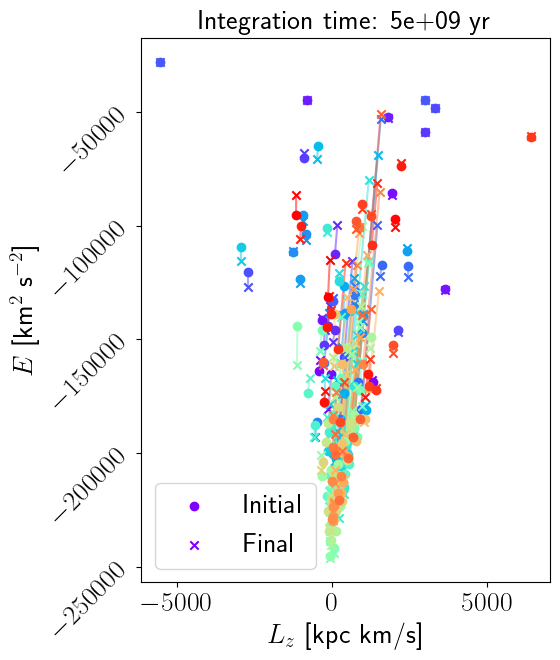

In [143]:
fig,axis=plt.subplots(1,1,figsize=(6,7))
AXIS = {
    "xlabel": r"$L_z$ [kpc km/s]",
    "ylabel": r"$E$ [km$^{2}$ s$^{-2}$]",
    "title": "Integration time: {:.0e} yr".format(integrationTime),
}
for i in range(Nobj):
    if i ==0:
        axis.scatter(Lz0[i],E0[i],color=colors[i],label="Initial")
        axis.scatter(LzF[i],EF[i],color=colors[i],marker='x',label="Final")
    else:
        axis.scatter(Lz0[i],E0[i],color=colors[i])
        axis.scatter(LzF[i],EF[i],color=colors[i],marker='x')
    axis.plot([Lz0[i],LzF[i]],[E0[i],EF[i]],color=colors[i],alpha=0.5,zorder=0)
axis.set(**AXIS)
axis.tick_params(axis='y', rotation=45)
axis.legend()
fig.tight_layout()  

In [145]:
print(GCdata['Cluster'][np.argmin((E0 - EF)**2)])
print(GCdata['Cluster'][np.argmin((Lz0 - LzF)**2)])

Ter2
Pal4


# Now add a stream to go forward

In [107]:
targetCluster = "NGC5139"
clusterIndex=np.where(GCdata['Cluster'] == targetCluster)[0][0]

make plummer sphere

In [108]:
Mass = GCdata['Mass'][clusterIndex] 
halfMassRadius = GCdata['rh_m'][clusterIndex]
bPlummer = tstrippy.ergodic.convertHalfMassRadiusToPlummerRadius(halfmassradius=halfMassRadius)
NP = int(1e3)

In [109]:
xp,yp,zp,vxp,vyp,vzp=tstrippy.ergodic.isotropicplummer(G,halfMassRadius.value,bPlummer.value,NP)

Extract host cluster

In [110]:
xH,yH,zH,vxH,vyH,vzH=xt[clusterIndex],yt[clusterIndex],zt[clusterIndex],vxt[clusterIndex],vyt[clusterIndex],vzt[clusterIndex]

flip the orbit and change sign of the velocities

In [111]:
xH,yH,zH=np.flip(xH),np.flip(yH),np.flip(zH)
vxH,vyH,vzH=-np.flip(vxH),-np.flip(vyH),-np.flip(vzH)

create a time array

In [112]:
tH = np.linspace(-T.value,0,Ntimestep+1)

reset the time integration parameters to go forward
- note that when integrating the cluster orbits, t0=0
- now, t0 will be extracted from the first element host orbit's time array tH

In [113]:
T = integrationTime
dt = timestep
Ntimestep=int(T/dt)
T,dt=T*u.yr,dt*u.yr
T,dt=T.to(unitT),dt.to(unitT)
currenttime = -T

make the bar spin the other way

## Initialize the integrator

In [114]:
tstrippy.integrator.setstaticgalaxy("pouliasis2017pii",MWparams)
tstrippy.integrator.setinitialkinematics(xp+xH[0],yp+yH[0],zp+zH[0],vxp+vxH[0],vyp+vyH[0],vzp+vzH[0])
tstrippy.integrator.setintegrationparameters(currenttime.value,dt.value,Ntimestep)
tstrippy.integrator.inithostperturber(tH,xH,yH,zH,vxH,vyH,vzH,Mass.value,bPlummer.value)
tstrippy.integrator.initgalacticbar("longmuralibar",barparams,barpolycoeff)
starttime=datetime.datetime.now()
tstrippy.integrator.leapfrogtofinalpositions()
endtime=datetime.datetime.now()
xf=tstrippy.integrator.xf.copy()
yf=tstrippy.integrator.yf.copy()
zf=tstrippy.integrator.zf.copy()
vxf=tstrippy.integrator.vxf.copy()
vyf=tstrippy.integrator.vyf.copy()
vzf=tstrippy.integrator.vzf.copy()
print(tstrippy.integrator.currenttime)
print("execution time", endtime-starttime)
tstrippy.integrator.deallocate()

-9.333245981624216e-15
execution time 0:00:00.150225


# Look at the result

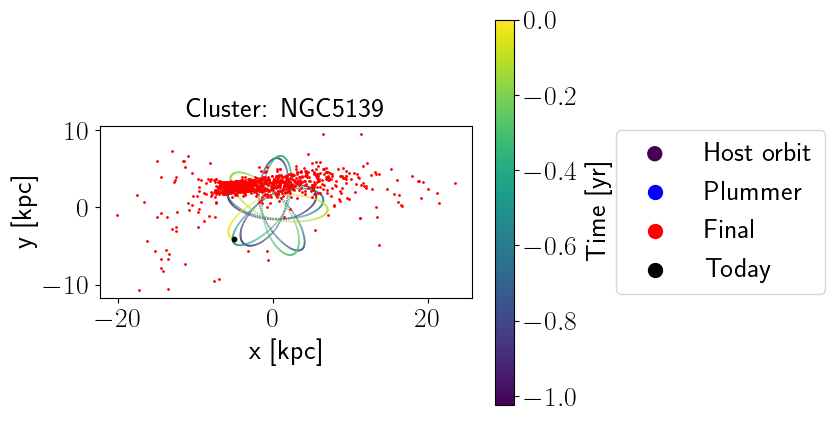

In [115]:
fig,axis=plt.subplots(1,1,figsize=(6,5))
im=axis.scatter(xH,yH,c=tH,cmap='viridis',s=0.1,label="Host orbit")
axis.scatter(xp+xH[0],yp+yH[0],color='blue',label="Plummer",s=4)
axis.scatter(xf,yf,color='red',label="Final",s=1)
axis.scatter(xH[-1],yH[-1],color='black',label="Today",s=10)
fig.colorbar(im,ax=axis,label="Time [yr]")
axis.set_aspect("equal")
axis.set(xlabel="x [kpc]",ylabel="y [kpc]",title="Cluster: {}".format(targetCluster))
legend = axis.legend(loc='center left', bbox_to_anchor=(1.35, 0.5))
for handle in legend.legendHandles:
    handle.set_sizes([100])

## Check if orbit can be reproduced with the bar 

In [22]:
integrationTime = 3e9
timestep = 1e7
theta0= 25 * (np.pi/180) 
omega =  -28  * 2*np.pi * unitV / unitD
barpolycoeff=[theta0,omega.value]

### Backward orbit

In [23]:
Ntimestep=int(integrationTime/timestep)
T,dt=integrationTime*u.yr,timestep*u.yr
T,dt=T.to(unitT),dt.to(unitT)
currenttime = 0*unitT

In [24]:
targetCluster = "NGC5139"
clusterIndex=np.where(GCdata['Cluster'] == targetCluster)[0][0]
galacticcoordinates
x0,y0,z0,=galacticcoordinates.cartesian.xyz.to(unitD).value[:,clusterIndex]
vx0,vy0,vz0=galacticcoordinates.velocity.d_xyz.to(unitV).value[:,clusterIndex]

#### BACKWARD IN TIME HAS A POSITIVE SIGN FOR BAR SPEED

In [25]:
tstrippy.integrator.setintegrationparameters(currenttime.value,dt.value,Ntimestep)
tstrippy.integrator.setbackwardorbit()
tstrippy.integrator.setstaticgalaxy("pouliasis2017pii",MWparams)
tstrippy.integrator.setinitialkinematics(x0,y0,z0,vx0,vy0,vz0) # change the sign because we are going backward in time
tstrippy.integrator.initgalacticbar("longmuralibar",barparams,barpolycoeff)
xBackward,yBackward,zBackward,vxBackward,vyBackward,vzBackward=tstrippy.integrator.leapfrogintime(Ntimestep,1)
print(tstrippy.integrator.currenttime)
tstrippy.integrator.deallocate()

-3.068136495137076


### Forward orbit from this position

In [26]:
currenttime=-T
xB0,yB0,zB0=xBackward[0,-1],yBackward[0,-1],zBackward[0,-1]
vxB0,vyB0,vzB0=-vxBackward[0,-1],-vyBackward[0,-1],-vzBackward[0,-1]

In [27]:
import datetime

In [28]:
tstrippy.integrator.setintegrationparameters(currenttime.value,dt.value,Ntimestep)
tstrippy.integrator.setstaticgalaxy("pouliasis2017pii",MWparams)
tstrippy.integrator.setinitialkinematics(xB0,yB0,zB0,vxB0,vyB0,vzB0) # change the sign because we are going backward in time
tstrippy.integrator.initgalacticbar("longmuralibar",barparams,barpolycoeff)
starttime=datetime.datetime.now()
xForward,yForward,zForward,vxForward,vyForward,vzForward=tstrippy.integrator.leapfrogintime(Ntimestep,1)
endtime=datetime.datetime.now()
print(tstrippy.integrator.currenttime)
print("Time taken: ",endtime-starttime)
tstrippy.integrator.deallocate()

-8.805456364058273e-15
Time taken:  0:00:00.001207


In [70]:
timestep=1e4
np.linspace(1e9,5e9,21)[2]/timestep

3e9/4e6

750.0

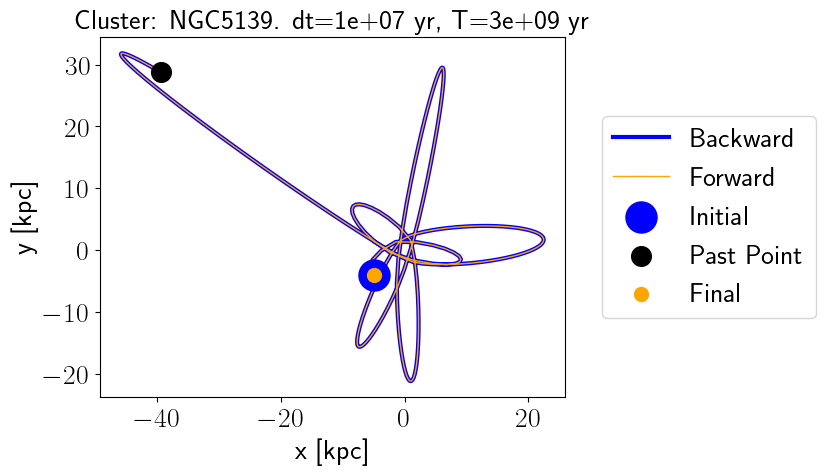

In [29]:
fig,axis=plt.subplots(1,1,figsize=(6,5))
axis.plot(xBackward[0],yBackward[0],zorder=0,linewidth=3,label="Backward",color="blue")
axis.plot(xForward[0],yForward[0],zorder=0,linewidth=1,label="Forward",color='orange')

axis.scatter(x0,y0,color='blue',label="Initial",s=500)
axis.scatter(xB0,yB0,color='k',label="Past Point",s=200)
axis.scatter(xForward[0,-1],yForward[0,-1],color='orange',label="Final",s=100)
axis.set_aspect("equal")
axis.set(xlabel="x [kpc]",ylabel="y [kpc]",title="Cluster: {}. dt={:.0e} yr, T={:.0e} yr".format(targetCluster,timestep,integrationTime))
axis.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))

From the file

In [34]:
import tstrippy
import astropy.units as u
import astropy.constants as const
import astropy.coordinates as coord
import numpy as np
import matplotlib.pyplot as plt
import datetime
import bar_sensitivity_integration_timestep_and_time as bsitt

In [35]:
targetGC="NGC5139"
unitT, unitV, unitD, unitM, unitG, G=bsitt.loadunits()
# Load the galaxy parameters
MWparams, MWrefframe = bsitt.loadGalaxy()
# Load the bar parameters
barparams = bsitt.barparams_ferrone2023()
# Load the bar movement
barpolycoeff = bsitt.bar_movement_ferrone2023()
# Reduce the mass of the disks to account for the bar
MWparams[5] = 1120.0 * 2.32*10**7 
MWparams[8] = 1190.0 * 2.32*10**7 
# Extract the initial conditions of the target globular cluster
x0,y0,z0,vx0,vy0,vz0 = bsitt.pick_globular_cluster(targetGC, MWrefframe)

#### Begin storing the input data for the integrator
Galaxy = ["pouliasis2017pii", MWparams]
bar = ["longmuralibar", barparams, barpolycoeff]
initialkinematics = [x0,y0,z0,vx0,vy0,vz0]
# Pick the target globular cluster
integrationtime = 1e9
timestep = 1e7

In [36]:
backwardorbit, forwardorbit=bsitt.backward_and_forward_orbit(integrationtime,timestep,Galaxy,initialkinematics,bar)

Backward orbit took 0:00:00.000431
Forward orbit took 0:00:00.000364


In [40]:
plotdata0={"x":backwardorbit[0],"y":backwardorbit[1]}
pltobj0={"label":"Backward orbit","color":"blue"}
plotdata1={"x":forwardorbit[0],"y":forwardorbit[1]}
pltobj1={"label":"Forward orbit","color":"orange"}
title=title="Cluster: {}. dt={:.0e} yr, T={:.0e} yr".format(targetGC,timestep,integrationtime)
axisconfig={
    'xlabel':"X [kpc]",
    'ylabel':"Y [kpc]",
    'aspect':'equal',
    'title':title}
